In [ ]:
!unzip /content/drive/MyDrive/DataSet/작물병해/data.zip

Archive:  /content/drive/MyDrive/DataSet/작물병해/data.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.csv               
  inflating: train.zip               


In [ ]:
!unzip /content/train.zip

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import os
import json 
import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from sklearn.metrics import f1_score

In [ ]:
sample = 10027

sample_csv = pd.read_csv(f'train/{sample}/{sample}.csv')
sample_image = cv2.imread(f'train/{sample}/{sample}.jpg')
sample_json = json.load(open(f'train/{sample}/{sample}.json', 'r'))

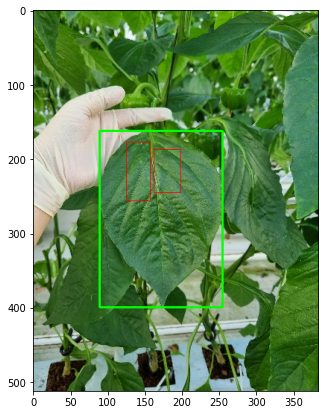

In [ ]:
# visualize bbox
plt.figure(figsize=(7,7))
points = sample_json['annotations']['bbox'][0]
part_points = sample_json['annotations']['part']
img = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

cv2.rectangle(
    img,
    (int(points['x']), int(points['y'])),
    (int((points['x']+points['w'])), int((points['y']+points['h']))),
    (0, 255, 0),
    2
)
for part_point in part_points:
    point = part_point
    cv2.rectangle(
        img,
        (int(point['x']), int(point['y'])),
        (int((point['x']+point['w'])), int((point['y']+point['h']))),
        (255, 0, 0),
        1
    )
plt.imshow(img)
plt.show()

# 데이터 로드 

## 환경 데이터 통계량 계산 for MinMax Scaling

In [ ]:
# 분석에 사용할 feature 선택
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
                '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

csv_files = sorted(glob('train/*/*.csv'))

temp_csv = pd.read_csv(csv_files[0])[csv_features]
max_arr, min_arr = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()

# feature 별 최대값, 최솟값 계산
for csv in tqdm(csv_files[1:]):
  try:
    temp_csv = pd.read_csv(csv)[csv_features]
    temp_max, temp_min = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()
    max_arr = np.max([max_arr,temp_max], axis=0)
    min_arr = np.min([min_arr,temp_min], axis=0)
  except:
    pass

# feature 별 최대값, 최솟값 dictionary 생성
csv_feature_dict = {csv_features[i]:[min_arr[i], max_arr[i]] for i in range(len(csv_features))}
csv_feature_dict

100%|██████████| 5766/5766 [00:56<00:00, 102.33it/s]


{'내부 습도 1 최고': [25.9, 100.0],
 '내부 습도 1 최저': [22.0, 100.0],
 '내부 습도 1 평균': [23.7, 100.0],
 '내부 온도 1 최고': [3.4, 47.6],
 '내부 온도 1 최저': [3.3, 47.0],
 '내부 온도 1 평균': [3.4, 47.3],
 '내부 이슬점 최고': [0.2, 34.7],
 '내부 이슬점 최저': [0.0, 34.4],
 '내부 이슬점 평균': [0.1, 34.5]}

# CustomDataset 제작

## 라벨 인코딩

In [ ]:
label_description = {
"1_00_0" : "딸기", 
"2_00_0" : "토마토",
"2_a5_2" : "토마토_흰가루병_중기",
"3_00_0" : "파프리카",
"3_a9_1" : "파프리카_흰가루병_초기",
"3_a9_2" : "파프리카_흰가루병_중기",
"3_a9_3" : "파프리카_흰가루병_말기",
"3_b3_1" : "파프리카_칼슘결핍_초기",
"3_b6_1" : "파프리카_다량원소결필(N)_초기",
"3_b7_1" : "파프리카_다량원소결필(P)_초기",
"3_b8_1" : "파프리카_다량원소결필(K)_초기",
"4_00_0" : "오이",
"5_00_0" : "고추",
 "5_a7_2" : "고추_탄저병_중기",
 "5_b6_1" : "고추_다량원소결필(N)_초기",
"5_b7_1" : "고추_다량원소결필(P)_초기",
 "5_b8_1" : "고추_다량원소결필(K)_초기",
"6_00_0" : "시설포도",
"6_a11_1" : "시설포도_탄저병_초기",
 "6_a11_2" : "시설포도_탄저병_중기",
 "6_a12_1" : "시설포도_노균병_초기",
"6_a12_2" : "시설포도_노균병_중기",
 "6_b4_1" : "시설포도_일소피해_초기",
 "6_b4_3" : "시설포도_일소피해_말기",
"6_b5_1" : "시설포도_축과병_초기"   }

label_encoder = {key:idx for idx, key in enumerate(label_description)}
label_decoder = {val:key for key, val in label_encoder.items()}

## 커스텀 데이터 

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, files, labels=None, mode='train'):
        self.mode = mode
        self.files = files
        self.csv_feature_dict = csv_feature_dict
        self.csv_feature_check = [0]*len(self.files)
        self.csv_features = [None]*len(self.files)
        self.max_len = -1 * 24*6
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        file = self.files[i]
        file_name = file.split('/')[-1]
        
        json_path = f'{file}/{file_name}.json'
        image_path = f'{file}/{file_name}.jpg'
        
        if self.csv_feature_check[i] == 0:
            csv_path = f'{file}/{file_name}.csv'
            df = pd.read_csv(csv_path)

            # MinMax scaling
            for col in self.csv_feature_dict.keys():
                df[col] = df[col] - self.csv_feature_dict[col][0]
                df[col] = df[col] / (self.csv_feature_dict[col][1]-self.csv_feature_dict[col][0])
            
            # transpose to sequential data
            csv_feature = df[self.csv_feature_dict.keys()].to_numpy()[self.max_len:].T
            self.csv_features[i] = csv_feature
            self.csv_feature_check[i] = 1
        else:
            csv_feature = self.csv_features[i]
        
        img = cv2.imread(image_path)
        img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32)/255
        img = np.transpose(img, (2,0,1))
        
        if self.mode == 'train':
            with open(json_path, 'r') as f:
                json_file = json.load(f)
            
            crop = json_file['annotations']['crop']
            disease = json_file['annotations']['disease']
            risk = json_file['annotations']['risk']
            label = f'{crop}_{disease}_{risk}'
            
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32),
                'label' : torch.tensor(self.label_encoder[label], dtype=torch.long)
            }
        else:
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32)
            }

# 하이퍼 파라미터

In [ ]:
device = torch.device("cuda:0")
batch_size = 256
class_n = len(label_encoder)
learning_rate = 1e-4
embedding_dim = 512
num_features = len(csv_feature_dict)
max_len = 24*6
dropout_rate = 0.1
epochs = 30
vision_pretrain = True
save_path = 'best_model.pt'

# 데이터셋 구성

In [ ]:
data_files = glob('train/*')
index = 100
train = data_files[:index]
val = data_files[index:]

In [ ]:
train_dataset = CustomDataset(train)
val_dataset = CustomDataset(val)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=16, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# 모델 

## 이미지 분류 모델

In [ ]:
class CNN_Encoder(nn.Module):
    def __init__(self, class_n, rate=0.1):
        super(CNN_Encoder, self).__init__()
        self.model = models.resnet50(pretrained=True)
    
    def forward(self, inputs):
        output = self.model(inputs)
        return output

## 시계열 모델 : LSTM

In [ ]:
class RNN_Decoder(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(RNN_Decoder, self).__init__()
        self.lstm = nn.LSTM(max_len, embedding_dim)
        self.rnn_fc = nn.Linear(num_features*embedding_dim, 1000)
        self.final_layer = nn.Linear(1000 + 1000, class_n)
        self.dropout = nn.Dropout(rate)

    def forward(self, enc_out, dec_inp):
        hidden, _ = self.lstm(dec_inp)
        hidden = hidden.view(hidden.size(0), -1)
        hidden = self.rnn_fc(hidden)
        concat = torch.cat([enc_out, hidden], dim=1) # enc_out + hidden 
        fc_input = concat
        output = self.dropout((self.final_layer(fc_input)))
        return output

## 앙상블 

In [ ]:
class CNN2RNN(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(CNN2RNN, self).__init__()
        self.cnn = CNN_Encoder(embedding_dim, rate)
        self.rnn = RNN_Decoder(max_len, embedding_dim, num_features, class_n, rate)
        
    def forward(self, img, seq):
        cnn_output = self.cnn(img)
        output = self.rnn(cnn_output, seq)
        
        return output

In [ ]:
model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=dropout_rate)
model = model.to(device)

# 학습 

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
def accuracy_function(real, pred):    
    real = real.cpu()
    pred = torch.argmax(pred, dim=1).cpu()
    score = f1_score(real, pred, average='macro')
    return score

def train_step(batch_item, training):
    img = batch_item['img'].to(device)
    csv_feature = batch_item['csv_feature'].to(device)
    label = batch_item['label'].to(device)
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(img, csv_feature)
            loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        score = accuracy_function(label, output)
        return loss, score
    else:
        model.eval()
        with torch.no_grad():
            output = model(img, csv_feature)
            loss = criterion(output, label)
        score = accuracy_function(label, output)
        return loss, score

In [ ]:
loss_plot, val_loss_plot = [], []
metric_plot, val_metric_plot = [], []

for epoch in range(epochs):
    total_loss, total_val_loss = 0, 0
    total_acc, total_val_acc = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_loss += batch_loss
        total_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Loss' : '{:06f}'.format(total_loss/(batch+1)),
            'Mean F-1' : '{:06f}'.format(total_acc/(batch+1))
        })
    loss_plot.append(total_loss/(batch+1))
    metric_plot.append(total_acc/(batch+1))
    
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_val_loss += batch_loss
        total_val_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
            'Mean Val F-1' : '{:06f}'.format(total_val_acc/(batch+1))
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    val_metric_plot.append(total_val_acc/(batch+1))
    
    if np.max(val_metric_plot) == val_metric_plot[-1]:
        torch.save(model, save_path)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
0it [00:00, ?it/s]


NameError: ignored

# 샘플 코드 - 이미지만 사용 

In [ ]:
!pip install timm

     |████████████████████████████████| 431 kB 8.0 MB/s 


In [ ]:
import warnings
warnings.filterwarnings('ignore')

from glob import glob
import pandas as pd
import numpy as np 
from tqdm import tqdm
import json
import cv2
import matplotlib.pyplot as plt

import os
import timm
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import time



device = torch.device('cuda')
def accuracy_function(real, pred):    
    score = f1_score(real, pred, average='macro')
    return score

def model_save(model, score,  path):
    os.makedirs('model', exist_ok=True)
    torch.save({
        'model': model.state_dict(),
        'score': score
    }, path)

## 데이터로드

In [ ]:
train_csv = sorted(glob('train/*/*.csv'))
train_jpg = sorted(glob('train/*/*.jpg'))
train_json = sorted(glob('train/*/*.json'))


crops = []
diseases = []
risks = []
labels = []

for i in range(len(train_json)):
    with open(train_json[i], 'r') as f:
        sample = json.load(f)
        crop = sample['annotations']['crop']
        disease = sample['annotations']['disease']
        risk = sample['annotations']['risk']
        label=f"{crop}_{disease}_{risk}"
    
        crops.append(crop)
        diseases.append(disease)
        risks.append(risk)
        labels.append(label)
        
label_unique = sorted(np.unique(labels))
label_unique = {key:value for key,value in zip(label_unique, range(len(label_unique)))}

labels = [label_unique[k] for k in labels]



def img_load(path):
    img = cv2.imread(path)[:,:,::-1]
    img = cv2.resize(img, (384, 512))
    return img

imgs = [img_load(k) for k in tqdm(train_jpg)]


100%|██████████| 5767/5767 [00:43<00:00, 133.14it/s]


## 로더 클래스 정의 

In [ ]:
class Custom_dataset(Dataset):
    def __init__(self, img_paths, labels, mode='train'):
        self.img_paths = img_paths
        self.labels = labels
        self.mode=mode
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        img = self.img_paths[idx]
        
        if self.mode=='train':
            augmentation = random.randint(0,2)
            if augmentation==1:
                img = img[::-1].copy() #<--- 뒤집기 
            elif augmentation==2:
                img = img[:,::-1].copy() #<---- 좌우 반전 
        img = transforms.ToTensor()(img)
        if self.mode=='test':
            return img
        
        label = self.labels[idx]
        return img,label
    
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=25)
        
    def forward(self, x):
        x = self.model(x)
        return x    

## 데이터 분리 및 로더 정의 

In [ ]:
folds = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, valid_idx in kf.split(imgs):
    folds.append((train_idx, valid_idx))
fold=0
train_idx, valid_idx = folds[fold]

batch_size = 16
epochs = 30


train_dataset = Custom_dataset(np.array(imgs)[train_idx], np.array(labels)[train_idx], mode='train')
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, pin_memory=True, num_workers=8)

        
valid_dataset = Custom_dataset(np.array(imgs)[valid_idx], np.array(labels)[valid_idx], mode='valid')
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=batch_size, pin_memory=True, num_workers=8)


## 훈련 

In [ ]:
model = Network().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler() 



best=0
for epoch in range(epochs):
    start=time.time()
    train_loss = 0
    train_pred=[]
    train_y=[]
    model.train()
    for batch in (train_loader):
        optimizer.zero_grad()
        x = torch.tensor(batch[0], dtype=torch.float32, device=device)
        y = torch.tensor(batch[1], dtype=torch.long, device=device)
        with torch.cuda.amp.autocast():
            pred = model(x)
        loss = criterion(pred, y)


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()/len(train_loader)
        train_pred += pred.argmax(1).detach().cpu().numpy().tolist()
        train_y += y.detach().cpu().numpy().tolist()
        
    
    train_f1 = accuracy_function(train_y, train_pred)
    
    model.eval()
    valid_loss = 0
    valid_pred=[]
    valid_y=[]
    with torch.no_grad():
        for batch in (valid_loader):
            x = torch.tensor(batch[0], dtype=torch.float32, device=device)
            y = torch.tensor(batch[1], dtype=torch.long, device=device)
            with torch.cuda.amp.autocast():
                pred = model(x)
            loss = criterion(pred, y)
            valid_loss += loss.item()/len(valid_loader)
            valid_pred += pred.argmax(1).detach().cpu().numpy().tolist()
            valid_y += y.detach().cpu().numpy().tolist()
        valid_f1 = accuracy_function(valid_y, valid_pred)
    if valid_f1>=best:
        best=valid_f1
        model_save(model, valid_f1, f'model/eff-b0.pth')
    TIME = time.time() - start
    print(f'epoch : {epoch+1}/{epochs}    time : {TIME:.0f}s/{TIME*(epochs-epoch-1):.0f}s')
    print(f'TRAIN    loss : {train_loss:.5f}    f1 : {train_f1:.5f}')
    print(f'VALID    loss : {valid_loss:.5f}    f1 : {valid_f1:.5f}    best : {best:.5f}')

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


epoch : 1/30    time : 73s/2122s
TRAIN    loss : 0.58557    f1 : 0.61243
VALID    loss : 0.33214    f1 : 0.71628    best : 0.71628
epoch : 2/30    time : 72s/2007s
TRAIN    loss : 0.27556    f1 : 0.80143
VALID    loss : 0.25132    f1 : 0.85088    best : 0.85088
epoch : 3/30    time : 72s/1931s
TRAIN    loss : 0.18784    f1 : 0.87861
VALID    loss : 0.21664    f1 : 0.82848    best : 0.85088
epoch : 4/30    time : 71s/1857s
TRAIN    loss : 0.15834    f1 : 0.88337
VALID    loss : 0.22627    f1 : 0.83950    best : 0.85088
epoch : 5/30    time : 72s/1790s
TRAIN    loss : 0.12498    f1 : 0.90594
VALID    loss : 0.20529    f1 : 0.88383    best : 0.88383
epoch : 6/30    time : 72s/1716s
TRAIN    loss : 0.11043    f1 : 0.92270
VALID    loss : 0.36329    f1 : 0.80092    best : 0.88383
epoch : 7/30    time : 72s/1646s
TRAIN    loss : 0.12464    f1 : 0.91941
VALID    loss : 0.28890    f1 : 0.80033    best : 0.88383
epoch : 8/30    time : 72s/1575s
TRAIN    loss : 0.11240    f1 : 0.91516
VALID    l